In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [371]:
sns.set_style("whitegrid")

In [372]:
wine_data = pd.read_csv("../winequality-red.csv")

In [373]:
# Tigran Fahradyan
data = wine_data.to_numpy()

CV = 5

def split_data(data, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(data))
    
    train_end = int(0.9 * len(data))

    train = data[indices[:train_end]]
    test = data[indices[train_end:]]

    return train, test

def replace_nans(train, test):
    train_mean = np.nanmean(train[:, :-1], axis=0)
    for dataset in [train, test]:
        for i in range(dataset.shape[1] - 1):
            nan_mask = np.isnan(dataset[:, i])
            dataset[nan_mask, i] = train_mean[i]
    return train, test

train, test = split_data(data, seed=42)
train, test = replace_nans(train, test)

X_train, y_train = train[:, :-1], train[:, -1].astype(int)
X_test, y_test = test[:, :-1], test[:, -1].astype(int)

In [374]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [375]:
# create validation dataset
train_end = int(0.8 * len(X_train_scaled))
X_valid_scaled, y_valid = X_train_scaled[train_end:], y_train[train_end:]
X_train_scaled, y_train = X_train_scaled[:train_end], y_train[:train_end]

In [376]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [377]:
def create_neural_network(hidden_sizes):
    layers = []
    for i in range(1, len(hidden_sizes)):
        layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
        if i != len(hidden_sizes) - 1:
            layers.append(nn.ReLU())

    return nn.Sequential(*layers).to(torch.float64)

In [378]:
def train_neural_network(
    nn_hparams,
    X_train_scaled,
    y_train,
    X_valid_scaled,
    y_valid
):
    # create dataloaders
    train_dataset = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train))
    train_loader = DataLoader(train_dataset, batch_size=nn_hparams["batch_size"], shuffle=True)
    
    model = create_neural_network(nn_hparams["hidden_sizes"])
    model = model.to(device)
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=nn_hparams["lr"],
        momentum=nn_hparams["momentum"],
        weight_decay=nn_hparams["weight_decay"]
    )

    metrics = {
        "train_loss": [],
        "valid_loss": []
    }

    print("Training...")
    for epoch in tqdm(range(nn_hparams["num_epochs"])):
        model.train()
        running_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().item()

        model.eval()
        # train_logits = model(torch.from_numpy(X_train_scaled))
        # train_loss = criterion(train_logits, torch.from_numpy(y_train)).detach().item()
        train_loss = running_loss / len(train_loader)
        
        valid_logits = model(torch.from_numpy(X_valid_scaled).to(device))
        # print(valid_logits)
        valid_loss = criterion(valid_logits, torch.from_numpy(y_valid).to(device)).detach().item()
    
        metrics["train_loss"].append(train_loss)
        metrics["valid_loss"].append(valid_loss)
        
    # cleanup
    gc.collect()
    torch.cuda.empty_cache()

    return model, metrics

Sequential(
  (0): Linear(in_features=11, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=10, bias=True)
)
Training...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 99.13it/s]


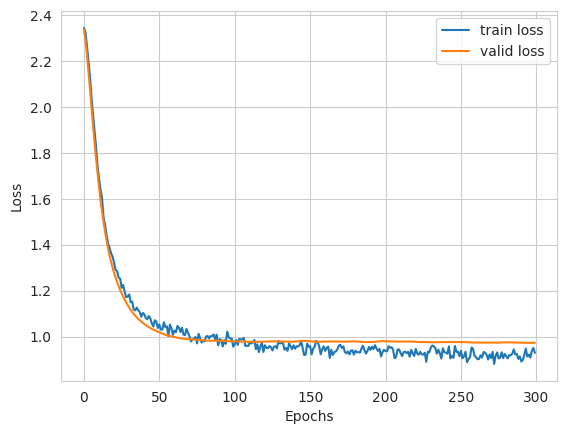

In [426]:
nn_hparams = {
    "batch_size": 512,
    "lr": 0.005,
    "momentum": 0.9,
    "weight_decay": 0.00,
    "num_epochs": 300,
    # "hidden_sizes": [X_train_scaled.shape[1], 24, 24, 10]
    "hidden_sizes": [X_train_scaled.shape[1], 24, 10]
}

model, metrics = train_neural_network(
    nn_hparams,
    X_train_scaled=X_train_scaled,
    y_train=y_train,
    X_valid_scaled=X_valid_scaled,
    y_valid=y_valid
)

plt.plot(metrics["train_loss"], label="train loss")
plt.plot(metrics["valid_loss"], label="valid loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [427]:
X_test_scaled = scaler.transform(X_test)

In [428]:
model.eval()
logits = model(torch.from_numpy(X_test_scaled).to(device))

In [429]:
(torch.argmax(logits, dim=1) == torch.from_numpy(y_test).to(device)).sum() / len(y_test)

tensor(0.6687)